# Модель GARCH

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 
from math import sqrt
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [71]:
data2 = pd.read_csv('monthly-sales-of-company-x-jan-6.csv').dropna().values[:,1] # удаляем пустые значеия и делаем массив из дф

In [57]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [58]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    """Функция для визуализации теста на стеционарность, оригинального графика значений, автокорреляции и частичной кореляции"""
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


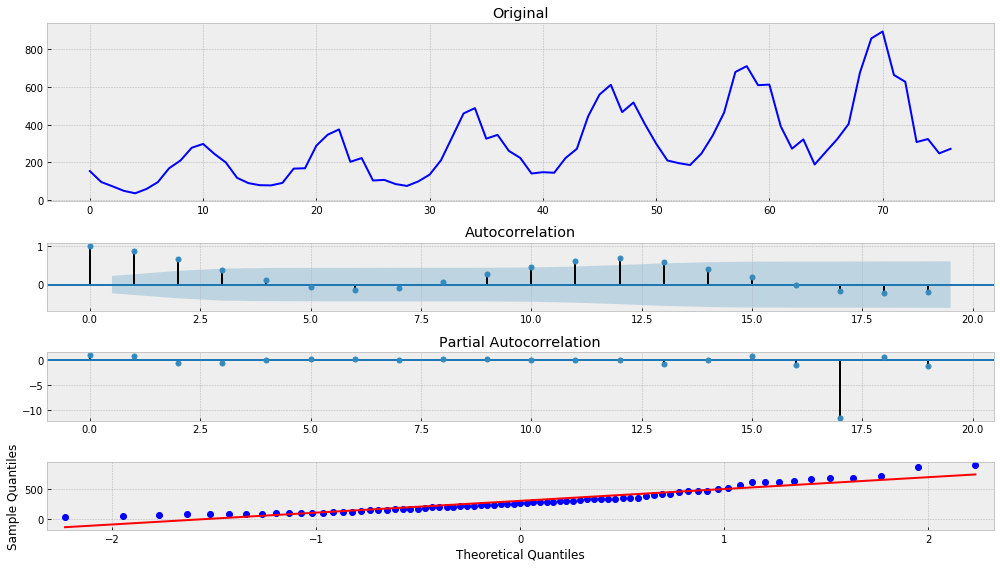

In [72]:
tsplot(data2)

Видим, что ряд нестационарен, поэтому для началу привидем его к стационарности

In [61]:
type(data2)

numpy.ndarray

In [73]:
#применим бокскокс
from scipy.stats import boxcox

data = boxcox(data.astype('float64'), 0)
data2 = boxcox(data2.astype('float64'), 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


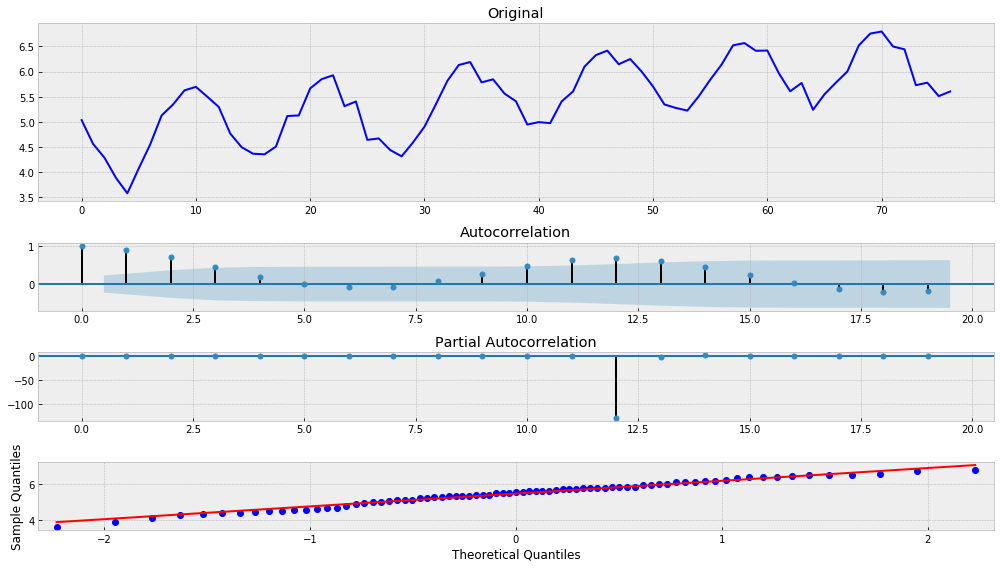

In [74]:
tsplot(data2)

In [75]:
#Уберем тренд
data2 = data2[2:] - data2[:-2]

Results of Dickey-Fuller Test:
Test Statistic                 -3.120934
p-value                         0.025042
#Lags Used                     10.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


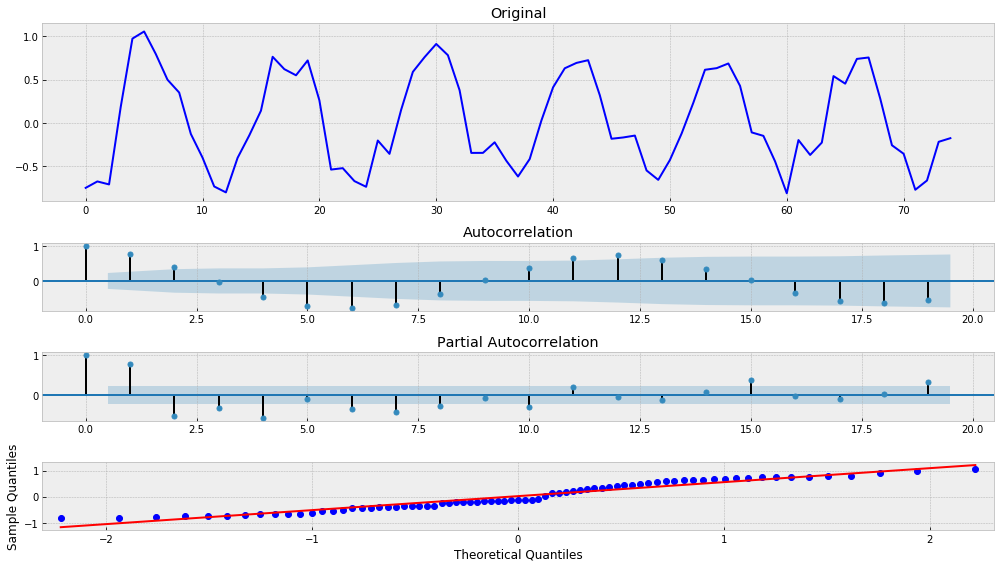

In [76]:
tsplot(data2)

In [77]:
len(data2)

75

In [82]:
n=50
train, test = data2[:n], data2[n:]

In [80]:
pip install arch

     |████████████████████████████████| 875 kB 2.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [88]:
from arch import arch_model
garch = arch_model(train, mean='Zero', vol='GARCH', p=3, q=14)
res = garch.fit(update_freq=5, disp='off')
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.020
Vol Model:                      GARCH   Log-Likelihood:               -39.0118
Distribution:                  Normal   AIC:                           114.024
Method:            Maximum Likelihood   BIC:                           148.440
                                        No. Observations:                   50
Date:                Mon, Jul 26 2021   Df Residuals:                       50
Time:                        13:18:40   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega      3.1432e-09      0.131  2.391e-08      1.000   [ -0.25

Results of Dickey-Fuller Test:
Test Statistic                 -1.966980
p-value                         0.301236
#Lags Used                     10.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


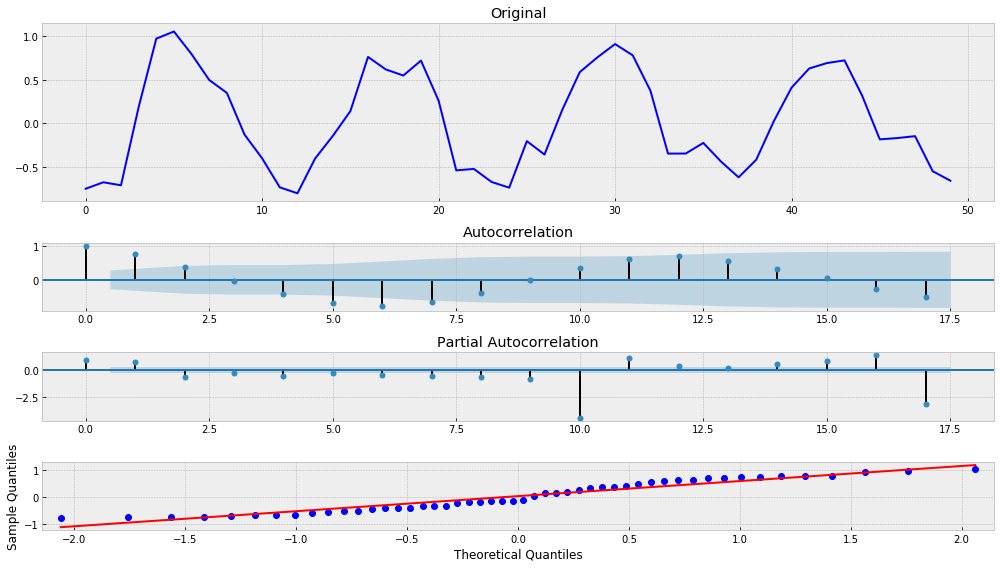

In [85]:
tsplot(res.resid)

In [92]:
# предсказания
pred = res.forecast(horizon=n)

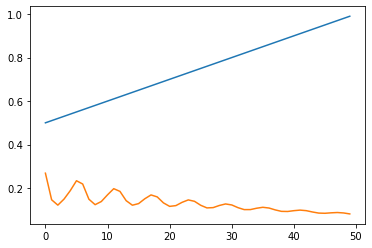

In [97]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n:])
plt.plot(pred.variance.values[-1, :])
plt.show()

как мы видим фактические значения растут, а предсказанные затухают, т е данная модель плохо работает на наших данных 